# Assignment 1a Notebook
This notebook will provide a series of tasks to guide you through the implementation of a random search algorithm. Conveniently, random search is often functionally equivalent to the random initialization step performed at the beginning of an evolutionary algorithm (EA). With that in mind, we'll try to structure this assignment so you can reuse your code throughout the course as you implement EA.

Start by evaluating the next cell to configure the notebook. If this is your first time using a Jupyter notebook, you can press `shift+enter` to execute the Python code in a selected cell.

In [1]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

print('The first cell has been executed!')

The first cell has been executed!


## Fitness Function
This semester we'll be exploring multiple problem domains where it may be appropriate to apply evolutionary computing. There will be two assignment series in which you will autonomously design bridges and evolve agents to play a simplified version of Ms. Pac-Man, respectively. In assignment series 1 (what you're doing now), your goal is to search for bridge designs that satisfy problem constraints in a physics simulation. To make this assignment more about your ability to understand and implement search algorithms, we're providing you with an implementation of the physics simulation and problem instances. The files `bridge_fitness.py` and `frame.py` implement the problem, and you are free to treat them as a black box. You won't have to understand or modify the code in those files, though you do need to understand the problem.

You will interact with this implementation by using a function `basic_simulation()` that takes as input a list of (x, y) coordinate pairs along with an assortment of problem-instance parameters. The list of (x, y) pairs you provide corresponds to joints within your bridge that are automatically connected to one another based on proximity. So, if the instance-specific parameter for this proximity is set to 3 m, then any points within 3 m of one another will be connected with a beam of some specific material and construction (e.g., a solid carbon fiber beam with a square cross-section). The problem instance also provides anchor points on the ground as points within a connected roadbed. Within the simulation, weight is increasingly applied and the bridge is scored by the weight at which it fails. This means that a stronger bridge will receive a higher score. The mechanics of this problem are not unlike those in the [Bridge Constructor](https://en.wikipedia.org/wiki/Bridge_Constructor) game franchise or [World of Goo](https://en.wikipedia.org/wiki/World_of_Goo).

The other important function we provide is `plot_bridge()`, which visualizes the relative forces acting on a bridge. The following cell will evaluate a hand-designed bridge and produce a score as described above, to show how these two functions work:

The bridge failed at a force of 7,500,000 N and receives a score of 7,500,000.
The following shows the structure of the bridge and the forces experienced during simulation.


/Users/joshua/Programming/Python/ECAssignments/bridge1a-boydjc/frame.py:568: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


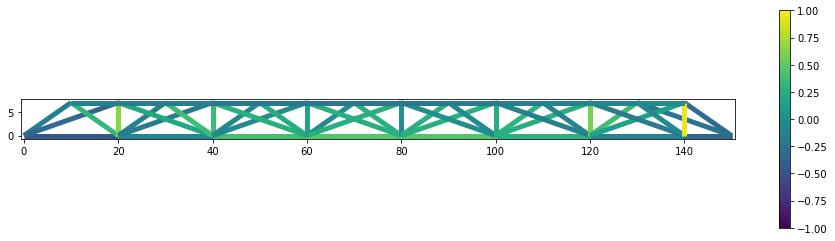

In [2]:
import json
from bridge_fitness import basic_simulation, plot_bridge

with open('configs/green1a_problem.json') as file:
    problem_instance = json.load(file)

bridge_points = [(10, 7), (20, 7), (30, 7), (40, 7), (50, 7), (60, 7), (70, 7), 
                   (80, 7), (90, 7), (100, 7), (110, 7), (120, 7), (130, 7), (140, 7)]

# Note: don't worry if this next line is confusing; we'll discuss it momentarily
score, bridge = basic_simulation(bridge_points, **problem_instance) 

print(f"The bridge failed at a force of {score:,} N and receives a score of {score:,}.")
print('The following shows the structure of the bridge and the forces experienced during simulation.')

plot_bridge(bridge)

# to prevent haphazard copypasta and global scope abuse
del problem_instance, bridge_points, score, bridge

### Aside: Keyword Parameter unpacking
Note that the above cell extracted parameters for the problem instance from a JSON file. These parameters represent the specific design problem we want to solve. Dictionary unpacking is an intermediate-level Python technique that we'll make extensive use of throughout the course. The following cell contains an example of a function that takes arbitrary keyword arguments (`**kwargs`) that are stored in a dictionary (named `kwargs`).

Execute the following cell for a brief demo of how to accept arbitrary named arguments and unpack named arguments from a dictionary. If you find yourself confused by this example or just want to read more, see [here](https://realpython.com/python-kwargs-and-args/).

In [3]:
def an_example_kwargs_function(**kwargs):
    print(kwargs)
    for key in kwargs:
        print(f'I got the key value pair {key}:{kwargs[key]}')

print('Example 1: direct named arguments')
an_example_kwargs_function(crossoverPoints=5, someOtherArguments='this is a string!')

print('\nExample 2: using unpacking')
packed_kwargs = {'crossoverPoints': 5, 'someOtherArguments': 'this is a string!'}
an_example_kwargs_function(**packed_kwargs)

print('\nExample 3: unpacking the problem instance parameters')
with open('configs/green1a_problem.json') as file:
    problem_instance = json.load(file)
an_example_kwargs_function(**problem_instance)

del packed_kwargs, problem_instance

Example 1: direct named arguments
{'crossoverPoints': 5, 'someOtherArguments': 'this is a string!'}
I got the key value pair crossoverPoints:5
I got the key value pair someOtherArguments:this is a string!

Example 2: using unpacking
{'crossoverPoints': 5, 'someOtherArguments': 'this is a string!'}
I got the key value pair crossoverPoints:5
I got the key value pair someOtherArguments:this is a string!

Example 3: unpacking the problem instance parameters
{'material': 'carbon fiber', 'solid': True, 'width': 0.125, 'fixed_points': [[0, 0], [150, 0]], 'load_points': [[20, 0], [40, 0], [60, 0], [80, 0], [100, 0], [120, 0], [140, 0]], 'connection_distance': 30, 'weight_resolution': 500000, 'relax_gravity': False}
I got the key value pair material:carbon fiber
I got the key value pair solid:True
I got the key value pair width:0.125
I got the key value pair fixed_points:[[0, 0], [150, 0]]
I got the key value pair load_points:[[20, 0], [40, 0], [60, 0], [80, 0], [100, 0], [120, 0], [140, 0]]
I 

## Random Initialization
Note that the representation of the bridge accepted by the simulation function is a little peculiar. In EA terms we call this a fixed-length string (not to be confused with a character string) and it's a classical representation EAs work well with. This is synomymous with a fixed-length linear genotype. Fixed-length refers to the fact that there are a predefined number of loci (locations for genes), and linear simply means it is a 1-dimensional vector. We've provided a partially-complete class (`LinearGenotype`) for this representation. 

For your first task, implement the `random_initialization()` method of this class (found in the `linear_genotype.py` file) to get the following cell to work. This function accepts inputs for list length, x bounds, and y bounds and should uniform randomly create a list of (x, y) tuples that adhere to the provided bounds and the specified length of the list. This function should store this list in the `gene` member variable of the calling object (`self`). Note that these coordinates must be generated as floating-point (real) values, NOT integers. *You can ignore the other methods of the `LinearGenotype` class until Assignment 1b.*

The function did something? True
Was the solution the right length? True
Is each element in the list a tuple? True
Is each element of each tuple a float? True
Did the solution adhere to the bounds? True
Was initialization actually random? True
The solution bridge looks like this:


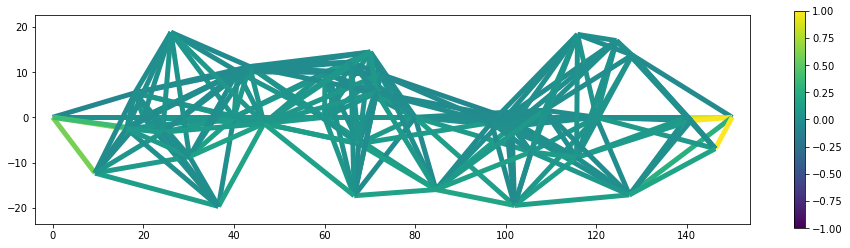

In [4]:
from linear_genotype import LinearGenotype

genotype_length = 30
genotype_x_bounds = [0, 150]
genotype_y_bounds = [-20, 20]

test_solution = LinearGenotype()
# We want this function to work!
test_solution.random_initialization(length=genotype_length, x_bounds=genotype_x_bounds, y_bounds=genotype_y_bounds)

# The following attempts to validate your implementation
print(f'The function did something? {test_solution.gene is not None}')
print(f'Was the solution the right length? {len(test_solution.gene) == genotype_length}')
print(f'Is each element in the list a tuple? {len([True for i in test_solution.gene if isinstance(i, tuple)]) == genotype_length}')
print(f'Is each element of each tuple a float? {len([True for x, y in test_solution.gene if isinstance(x, float) and isinstance(y, float)]) == genotype_length}')

def check_bound(value, low, high):
    return value >= low and value <= high
out_of_bounds = [True for x, y in test_solution.gene if not (check_bound(x, *genotype_x_bounds) and check_bound(y, *genotype_y_bounds))]
print(f'Did the solution adhere to the bounds? {len(out_of_bounds) == 0}')

another_solution = LinearGenotype()
another_solution.random_initialization(length=genotype_length, x_bounds=genotype_x_bounds, y_bounds=genotype_y_bounds)

# This has a very small chance of failing for correct implementations
print(f'Was initialization actually random? {another_solution.gene != test_solution.gene}')

print('The solution bridge looks like this:')

with open('configs/green1a_problem.json') as file:
    problem_instance = json.load(file)
_, bridge = basic_simulation(test_solution.gene, **problem_instance) 
plot_bridge(bridge)

del genotype_length, genotype_x_bounds, genotype_y_bounds, test_solution, out_of_bounds, another_solution, problem_instance, bridge

The fitness of the solution is 0


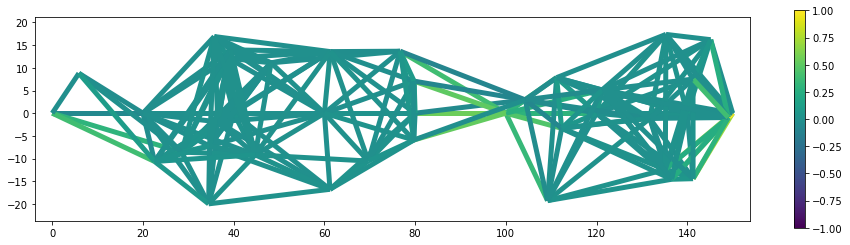

In [5]:
# Now let's evaluate a random solution and assign them a fitness and a bridge object (for visualization)
genotype_length = 30
genotype_x_bounds = [0, 150]
genotype_y_bounds = [-20, 20]

test_solution = LinearGenotype()
test_solution.random_initialization(length=genotype_length, x_bounds=genotype_x_bounds, y_bounds=genotype_y_bounds)

with open('configs/green1a_problem.json') as file:
    problem_instance = json.load(file)
test_solution.fitness, test_solution.bridge = basic_simulation(test_solution.gene, **problem_instance) 

print(f'The fitness of the solution is {test_solution.fitness:,}')
plot_bridge(test_solution.bridge)

del genotype_length, genotype_x_bounds, genotype_y_bounds, test_solution, problem_instance

### Fitness vs Score
You might have noticed that we switched from the term score to fitness in that last code block. We'll get into what fitness is in the lectures (if that hasn't already happened by the time you're reading this), but suffice to say for now that the fitness of our bridge is directly related to the weight it can support, and we want to maximize fitness.

You may also notice solutions that have a negative fitness. This indicates that a problem constraint wasn't satisfied and the bridge required modifications in order to perform a simulation. In Assignment 1c we'll look at other approaches for assigning fitnesses to solutions that violate constraints, but for now we'll just declare them invalid and arbitrarily assign a fitness of `-100`.

## Random Search Algorithm
At this point, you basically have everything you need to write a random search algorithm! Write a loop to generate new random solutions, evaluate them, and keep track of the best solution seen so far. If you feel lost, remember to look at how we evaluated solutions in the last few cells!

In [6]:
from math import inf

def random_search(number_solutions, length, x_bounds, y_bounds, problem_instance):
    best_fitness = -inf
    data = None
    
    solutionCount = 0
    # Search through and evaluate number_solutions different random solutions
    while not(solutionCount == number_solutions):
        solution = LinearGenotype()
        solution.random_initialization(length=length, x_bounds=x_bounds, y_bounds=y_bounds)
        solution.fitness, solution.bridge = basic_simulation(solution.gene, **problem_instance)
        
        if solution.fitness > best_fitness:
            best_fitness = solution.fitness
            data = solution.bridge
            
        solutionCount += 1
    
    # For the full experiment in the next section, you will need to collect data.
    # Feel free to ignore it for now, and you can come back to modify this function afterwards.
    
    return best_fitness, data

# Calling your function
with open('configs/green1a_problem.json') as file:
    print(random_search(number_solutions=5000, length=30, \
                  x_bounds=[0, 150], y_bounds=[-20, 20], \
                  problem_instance=json.load(file)))

(26500000, <frame.Frame object at 0x7fda5017b310>)


## Full Random Search Experiment
**IMPORTANT**: Before continuing, read the instructions here very carefully. You will need to change your function to record more data! You don't want to start your searches, wait several hours for them to finish, then find out you didn't actually record everything you need!

Using the code you wrote above, restart and run a random search with 5,000 evaluations 30 times (this can take several hours of computation). For each of the 30 runs, record the highest fitness encountered during the run. This data will be used later for statistical analysis.

For the bridge with the highest fitness across all runs, plot the bridge within this cell. Example code for visualizing can be found earlier in this notebook.

For the run that produced the highest fitness of all 30 runs, record data to produce a stairstep plot demonstrating the progress of this run as the search was performed. For reference, the stairstep plot should look something like the following:

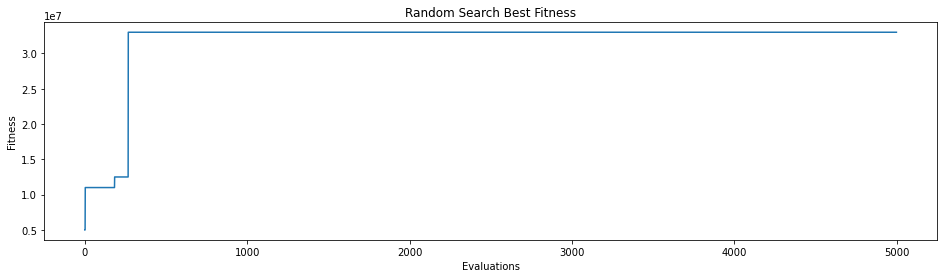

To reiterate, you will need:
* The highest fitness encountered in each run
    * 30 numbers, 1 per run
* The output of `plot_bridge()` of the best bridge in the experiment
* Data for generating the stairstep plot
    * Generated from the run that produced your best bridge
        * HINT: You can NOT determine which run that should be before recording this data -- the run would already be finished!
    * What this data should be, and how to record it, is left for you to decide. We will accept anything that can produce a complete & correct plot.

It is up to you to determine how to record and store the necessary data. You are also welcome to generate the stairstep graph using whatever software you like, though we recommend using `matplotlib`. Excel also works, but it gets very tedious using it for every dataset for every assignment.

The best fitness is: 62,000,000
This was first hit in run number: 5
In this run, the best fitness was first hit at solution number: 161
Best run fitnesses
[53000000, 50000000, 53000000, 57000000, 62000000, 49500000, 47000000, 54500000, 51500000, 48500000, 47500000, 48500000, 53000000, 62000000, 50000000, 48000000, 59000000, 58000000, 48000000, 45500000, 54000000, 52500000, 53500000, 49000000, 48500000, 55000000, 47000000, 50000000, 50500000, 52500000]

F Test
F Value: 4.6999419882755245	p Value: 3.899839876730926e-05

According to the f test, the variance of the two samples are not equal
T Test
T Value: -2.5646190249010448	p Value: 0.01410681224380176



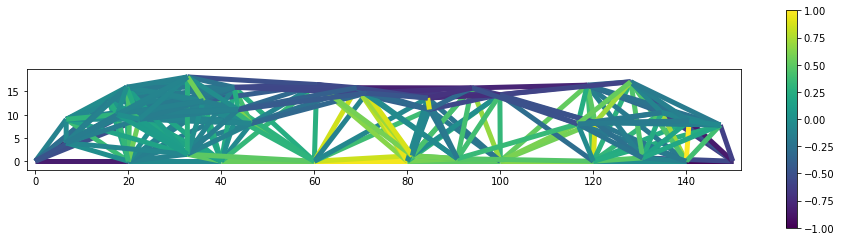

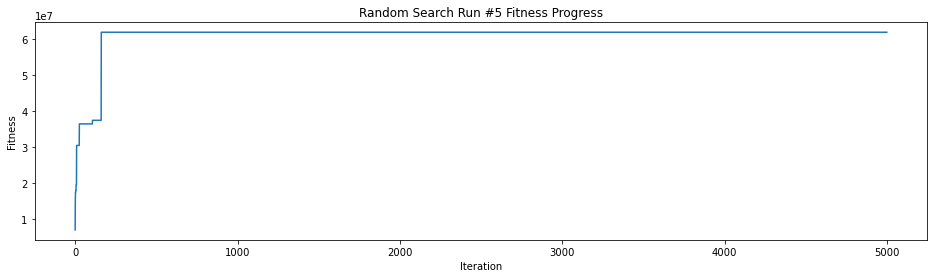

In [9]:
import scipy.stats
import numpy as np

number_of_runs = 30
bestFitnessSolutions = []

with open('configs/green1a_problem.json') as file:
    problem = json.load(file)

# Sample function call:
# random_search(number_solutions=5000, length=30, \
#         x_bounds=[0, 150], y_bounds=[-20, 20], \
#         problem_instance=problem)


# Write your random search experiment here and record metrics as described above
def random_search(number_solutions, length, x_bounds, y_bounds, problem_instance):
    best_fitness = -inf
    data = None
    progress = []
    
    
    solutionCount = 0
    while not(solutionCount == number_solutions):
        
        solution = LinearGenotype()
        solution.random_initialization(length=length, x_bounds=x_bounds, y_bounds=y_bounds)
        solution.fitness, solution.bridge = basic_simulation(solution.gene, **problem_instance)
            
        if solution.fitness > best_fitness:
            best_fitness = solution.fitness
            data = solution.bridge
            
        progress.append(best_fitness)
        
        solutionCount += 1
    
    return best_fitness, data, progress

def fTest(runFitnessResults, mysteryData):
    mysteryData = np.array(mysteryData)
    runFitnessResults = np.array(runFitnessResults)
    
    f = np.var(mysteryData, ddof=1)/np.var(runFitnessResults, ddof=1)
    a = 1-scipy.stats.f.cdf(f, mysteryData.size-1, runFitnessResults.size-1)
    
    return [f, a]

def tTest(runFitnessResults, mysteryData, equalVariance):
    mysteryData = np.array(mysteryData)
    runFitnessResults = np.array(runFitnessResults)
    
    tTestResults = scipy.stats.ttest_ind(a=mysteryData, b=runFitnessResults, equal_var=equalVariance)
    
    return [tTestResults.statistic, tTestResults.pvalue]

# start runs and analysis 
for run in range(number_of_runs):
    bestFitnessSolutions.append(random_search(number_solutions=5000, length=30, \
                      x_bounds=[0, 150], y_bounds=[0, 20], \
                      problem_instance=problem))
    

solutionFitnessResults = [solution[0] for solution in bestFitnessSolutions]

bestFitness = max(solutionFitnessResults)
bestFitnessLoc = solutionFitnessResults.index(bestFitness)
bestSolutionProgress = bestFitnessSolutions[bestFitnessLoc][2]

print(f'The best fitness is: {bestFitness:,}')
print(f'This was first hit in run number: {bestFitnessLoc+1}')
print(f'In this run, the best fitness was first hit at solution number: {bestSolutionProgress.index(bestFitness)}')
print('Best run fitnesses')
print(solutionFitnessResults)
plot_bridge(bestFitnessSolutions[bestFitnessLoc][1])
plt.figure()
plt.title(f'Random Search Run #{bestFitnessLoc+1} Fitness Progress')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.plot(range(len(bestSolutionProgress)), bestSolutionProgress);

mysteryData = []
with open('data/mysteryAlgorithmResults.txt') as mysteryFile:
    for line in mysteryFile:
        mysteryData.append(int(line))

print('\nF Test')
fTestResults = fTest(solutionFitnessResults, mysteryData)
print(f'F Value: {fTestResults[0]}\tp Value: {fTestResults[1]}\n')

if(fTestResults[1] < 0.05):
    print("According to the f test, the variance of the two samples are not equal")
else:
    print("According to the f test, the variance of the two samples are equal")

print('T Test')
tTestResults = None
if(fTestResults[1] < 0.05):
    equalVariance = False;
else:
    equalVariance = True;
tTestResults = tTest(solutionFitnessResults, mysteryData, equalVariance)
print(f'T Value: {tTestResults[0]}\tp Value: {tTestResults[1]}\n')

## Report
Now that you've completed the implementation of random search, use the data you've generated to create the report requested in the assignment description document.